<a href="https://colab.research.google.com/github/rainmaker29/FaceGAN/blob/master/FaceGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

## Visualize the CelebA Data



In [0]:
import torch
from torchvision import datasets
from torchvision import transforms

In [0]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    
    augementations = transforms.Compose([transforms.Resize(image_size),
                                        transforms.CenterCrop(image_size),
                                        transforms.ToTensor()])
    
    images = datasets.ImageFolder(data_dir,transform=augementations)
    
    dataloader = torch.utils.data.DataLoader(images,batch_size=batch_size+1,shuffle=True)
    
    
    return dataloader


## Create a DataLoader


In [0]:
# function hyperparameters
batch_size = 20
img_size = 32

# Calling function to get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


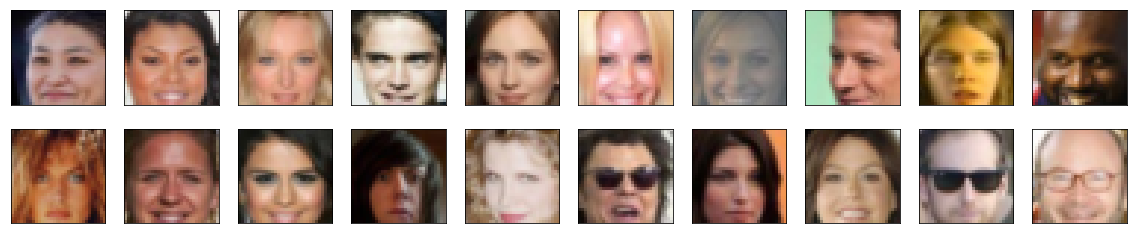

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [0]:
def scale(x, feature_range=(-1, 1)):
    
    minimum,maximum = feature_range
    
    x = x*(maximum-minimum) + minimum
    
    return x


In [0]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.6314)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator


In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)



In [0]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        
        super(Discriminator, self).__init__()

        
        self.conv_dim = conv_dim

        
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64 depth = 3
        self.conv2 = conv(conv_dim, conv_dim * 2, 4) # x, y = 32 depth = 64
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4) # x, y = 16 depth = 128
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        self.out = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        

    def forward(self, x):
        
        x = F.leaky_relu(self.conv1(x), 0.2)
        
        x = F.leaky_relu(self.conv2(x), 0.2)
        
        x = F.leaky_relu(self.conv3(x), 0.2)       
        x = x.view(-1, self.conv_dim*4*4*4)
        
        x = self.fc(x)
        x = self.dropout(x)
        
        return x



## Generator


In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []

    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()


        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4 )
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        self.dropout = nn.Dropout(0.5)
        

    def forward(self, x):

        x = self.fc(x)
        x = self.dropout(x)
        
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.t_conv1(x))
        
        x = F.relu(self.t_conv2(x))
        
        x = F.tanh(self.t_conv3(x))
        
        return x


## Weight Initialization


In [0]:
from torch.nn import init
def weights_init_normal(m):
    classname = m.__class__.__name__
    

    init_gain=0.02
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, init_gain)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)
    
    

## Network



In [0]:
def build_network(d_conv_dim, g_conv_dim, z_size):

    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [0]:
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (out): Sigmoid()
  (dropout): Dropout(p=0.5)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_s

### Training on GPU


In [0]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

## Discriminator and Generator Losses


In [0]:
import random
from random import randrange, uniform
def real_loss(D_out):
    batch_size = D_out.size(0)
    # smoothing the labels
    labels = torch.ones(batch_size) * np.random.uniform(0.7, 1.2)
    
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size) * np.random.uniform(0.0, 0.3) 
    
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers


In [0]:
import torch.optim as optim
lr = 0.0005
beta1= 0.1
beta2= 0.99


d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])


## Training


In [0]:
def train(D, G, n_epochs, print_every=50):
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keeping track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Getting some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            
            # Train the discriminator on real and fake images

            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            d_out = D(real_images)
            d_real_loss = real_loss(d_out)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            d_fake_out = D(fake_images)
            d_fake_loss = fake_loss(d_fake_out)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()

            # Train the generator with an adversarial loss            
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            # D.eval()
            # Computing the discriminator losses on fake images 
            # using flipped labels!
            g_fake_out = D(fake_images)
            g_loss = real_loss(g_fake_out) # use real loss to flip labels
            
            g_loss.backward()
            g_optimizer.step()           

            # Printing some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes generator is named G
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [0]:
# set number of epochs 
n_epochs = 2


# calling training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/    2] | d_loss: 1.4884 | g_loss: 1.1569
Epoch [    1/    2] | d_loss: 0.3170 | g_loss: 2.2477
Epoch [    1/    2] | d_loss: 1.2276 | g_loss: 1.7548
Epoch [    1/    2] | d_loss: 1.2515 | g_loss: 2.3823
Epoch [    1/    2] | d_loss: 1.3858 | g_loss: 1.1956
Epoch [    1/    2] | d_loss: 1.1390 | g_loss: 1.7879
Epoch [    1/    2] | d_loss: 0.9686 | g_loss: 1.6147
Epoch [    1/    2] | d_loss: 1.1360 | g_loss: 1.8186
Epoch [    1/    2] | d_loss: 1.5578 | g_loss: 0.8151
Epoch [    1/    2] | d_loss: 1.4920 | g_loss: 1.3770
Epoch [    1/    2] | d_loss: 0.9904 | g_loss: 1.3600
Epoch [    1/    2] | d_loss: 0.8918 | g_loss: 1.6267
Epoch [    1/    2] | d_loss: 1.4079 | g_loss: 0.9883
Epoch [    1/    2] | d_loss: 1.2804 | g_loss: 1.1483
Epoch [    1/    2] | d_loss: 1.2155 | g_loss: 1.9836
Epoch [    1/    2] | d_loss: 1.3204 | g_loss: 1.1230
Epoch [    1/    2] | d_loss: 1.4259 | g_loss: 1.3956
Epoch [    1/    2] | d_loss: 1.2916 | g_loss: 0.8148
Epoch [    1/    2] | d_loss

## Training loss


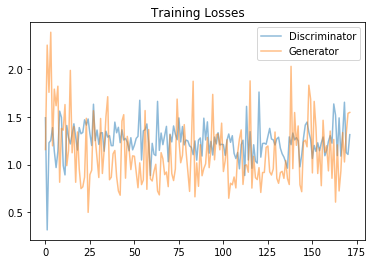

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training



In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [0]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

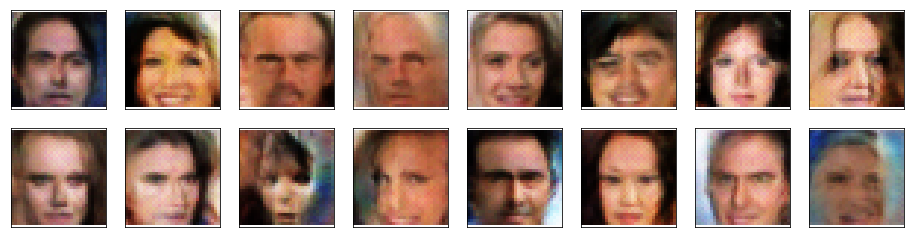

In [0]:
_ = view_samples(-1, samples)